In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [3]:
fly = 'fly_134'#'fly_153'#'fly_147'#'fly_152'#'fly_134'
anat_to_mean_type = 'myr'#'non_myr'
av_thresh = 50 #100 #50 #100
#standard
stim_start = 250
stim_stop = 300
# stim_start = 300
# stim_stop = 350

In [4]:
func_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly}/func_0/'

In [5]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 753 presented stimuli.
starts_angle_0: 374. starts_angle_180: 374


In [6]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [7]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 400

behavior_traces = {}
mean_trace = {}
sem_trace = {}
for angle in [0,180]:
    behavior_traces[angle],mean_trace[angle],sem_trace[angle] = brainsss.extract_traces(fictrac,
                                                                                        starts_angle[angle],
                                                                                        pre_window,
                                                                                        post_window)

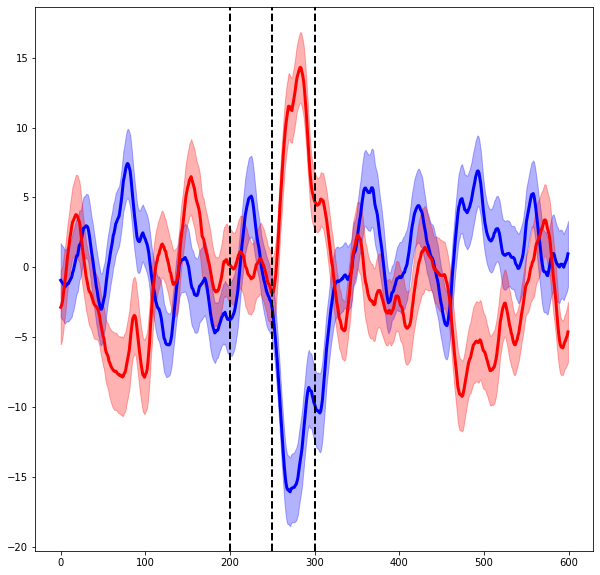

In [8]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    plt.plot(mean_trace[angle],color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_trace[angle])),mean_trace[angle]-sem_trace[angle], mean_trace[angle]+sem_trace[angle], color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [9]:
# # ### ve based on derivative sum.
# # ### I would like to assign a number to "turn quality"

# start = 300
# end = 350
# angle = 0

# behavior_traces_clipped = np.clip(behavior_traces[angle],None,0)
# traces_derivative = np.subtract(behavior_traces_clipped[:,:-1], behavior_traces_clipped[:,1:])
# #traces_derivative = np.clip(traces_derivative,None,0)
# turn_amount = np.sum(traces_derivative[:,start:end],axis=-1)
# sorted_indicies = np.argsort(turn_amount)
# sorted_traces = behavior_traces[angle][sorted_indicies,:]

# plt.figure(figsize=(10,10))
# plt.imshow(sorted_traces,aspect=5,cmap='seismic',vmin=-300,vmax=300)
# plt.axvline(300,color='k',linestyle='--',lw=2)
# plt.axvline(350,color='k',linestyle='--',lw=2)

In [10]:
#####################################
### Extract Visually Evoked Turns ###
#####################################
#fly 134
#r_thresh=.3, 
#av_thresh=50,

mean_turn = (mean_trace[0] + mean_trace[180]*-1)/2

ve_turns = {}
ve_turn_times = {}
for angle,direction in zip([0,180],['neg','pos']):
    ve_turns[angle], ve_turn_times[angle] = brainsss.get_visually_evoked_turns(behavior_traces[angle],
                                                                      mean_turn = mean_turn,
                                                                      start=stim_start, 
                                                                      stop=stim_stop, 
                                                                      r_thresh=.2, 
                                                                      av_thresh=av_thresh, 
                                                                      stim_times=starts_angle_ms[angle],
                                                                      expected_direction=direction)

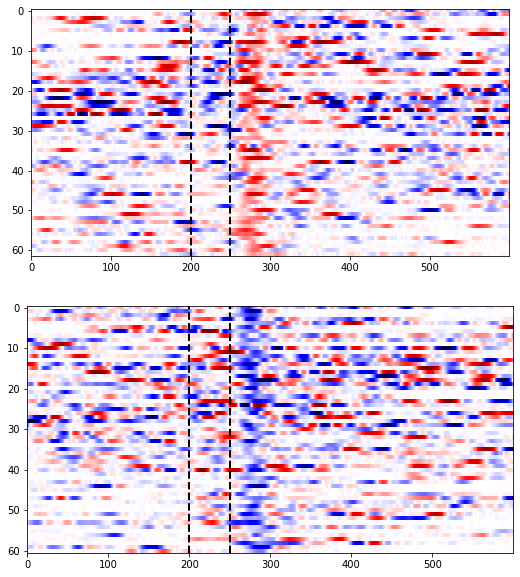

In [11]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

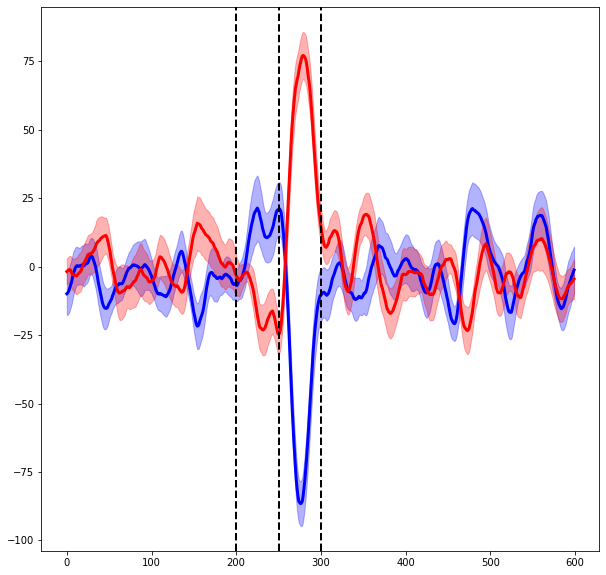

In [12]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [13]:
def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
    amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
    indicies = np.argsort(amount_of_behavior)
    top_x_indicies = indicies[:num_traces_to_return]
    return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

In [14]:
# how do I get block times?
# a block should be 6.25min + 1min grey
# however each stim is actually a little longer than 2s, so 7.45 ends up cutting well
block_dur = 7.45 * 60 * 1000 # in ms
expt_len = 30 * 60 * 1000
block_edge_times = np.arange(0,expt_len,block_dur)
num_blocks = len(block_edge_times) - 1

# now I want to know how many ve turns came from each block
ve_block_ids = {}
all_traces_block_ids = {}
for angle in [0,180]:
    ve_block_ids[angle] = np.searchsorted(block_edge_times,ve_turn_times[angle])
    all_traces_block_ids[angle] = np.searchsorted(block_edge_times,starts_angle_ms[angle])
    
# now for each block, get the same number of no_ve as ve
# Take the ones with the least behavior, but this could be a problem if there is a lot of behavior
ve_no_turns = {}
ve_no_turn_times = {}
for angle in [0,180]:
    trace_length = behavior_traces[angle].shape[1]
    #will append each block to these empty arrays
    ve_no_turns[angle] = np.empty((0,trace_length))
    ve_no_turn_times[angle] = np.empty((0))
    for block_num in range(1,num_blocks+1): # because blocks are not 0 indexed
        block_mask = all_traces_block_ids[angle] == block_num
        
        traces_no_turn, times_no_turn = get_stimuli_where_no_behavior(
            behavior_traces[angle][block_mask,:],
            start=stim_start,
            stop=stim_stop,
            # LOOK - asking for a few less with the 1.5
            num_traces_to_return=int(np.sum(ve_block_ids[angle]==block_num)), # get the same number as ve_turns
            stim_times=np.asarray(starts_angle_ms[angle])[block_mask]
        )
        
        ve_no_turns[angle] = np.concatenate((ve_no_turns[angle],traces_no_turn),axis=0)
        ve_no_turn_times[angle] = np.concatenate((ve_no_turn_times[angle],times_no_turn),axis=0)

In [15]:
# lets check what stimuli happen during the trial before the optomotor response
# it looks like it is enriched in opposite turns

stimulus_start_times_ms = np.asarray([int(i*100)*10 for i in stimulus_start_times])
for angle in [0,180]:
    stim_idxs = []
    for turn_time in ve_turn_times[0]:
        stim_idx = np.where(turn_time==stimulus_start_times_ms)[0][0]
        stim_idxs.append(angles[stim_idx-1])
    stim_idxs = np.asarray(stim_idxs)
    print(np.sum(stim_idxs==0) / np.sum(stim_idxs==180))


0.5945945945945946
0.5945945945945946


In [16]:
# 180 opto response has 3x more movement in 0 on the trial before


In [17]:
# this is if we don't care about blocks
# ve_no_turns = {}
# ve_no_turn_times = {}
# for angle in [0,180]:
#     ve_no_turns[angle], ve_no_turn_times[angle] = get_stimuli_where_no_behavior(behavior_traces[angle],
#                                   start=stim_start,
#                                   stop=stim_stop,
#                                   num_traces_to_return=len(ve_turns[angle]), # get the same number as ve_turns
#                                   stim_times=starts_angle_ms[angle])

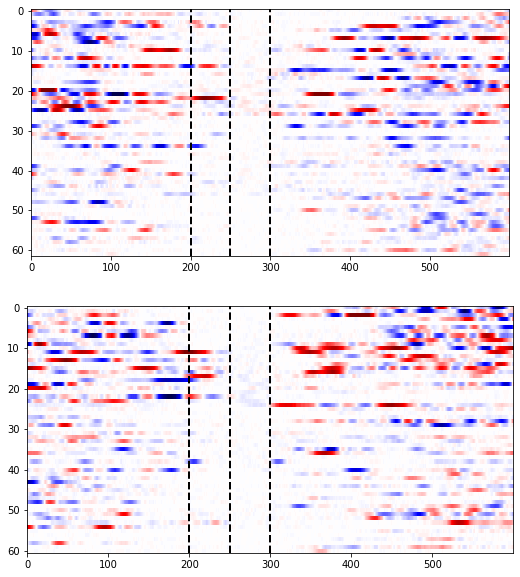

In [18]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_no_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_no_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

(-50, 50)

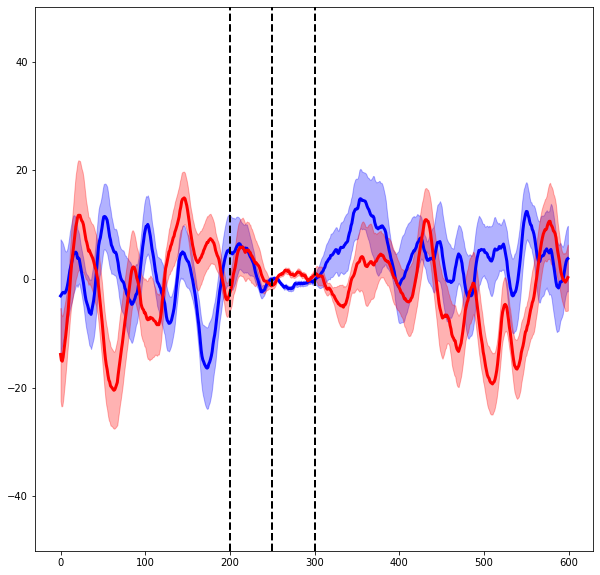

In [19]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_no_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_no_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.ylim(-50,50)

In [20]:
for i in all_stim_times:
    plt.axvline(i)
for i in block_starts:
    plt.axvline(i,color='r')

NameError: name 'all_stim_times' is not defined

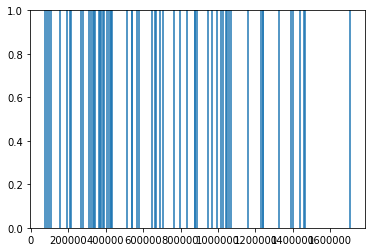

In [21]:
for i in ve_turn_times[0]:
    plt.axvline(i)

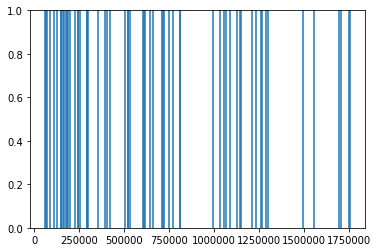

In [22]:
for i in ve_no_turn_times[0]:
    plt.axvline(i)

In [23]:
block_edge_times

array([      0.,  447000.,  894000., 1341000., 1788000.])

In [24]:
block_ids[180]

NameError: name 'block_ids' is not defined

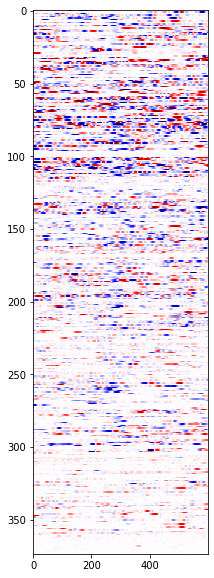

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(behavior_traces[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)

# load neural

In [26]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [27]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [28]:
fixed = brainsss.load_fda_meanbrain()

In [29]:
atlas = brainsss.load_roi_atlas()

In [30]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [31]:
bin_start = -1500; bin_end = 2000; bin_size = 100
#bin_start = -3100; bin_end = 2000; bin_size = 100
#bin_start = -3100; bin_end = 4000; bin_size = 100
#bin_start = -5100; bin_end = 6000; bin_size = 100
#bin_start = -500; bin_end = 1000; bin_size = 100

neural_bins = np.arange(bin_start,bin_end,bin_size)

# extract grey baseline

In [32]:
##########################
### GET WALKING VECTOR ###
##########################

y_std = fictrac['Y']/np.std(fictrac['Y'])
z_std = fictrac['Z']/np.std(fictrac['Z'])
movement = (y_std**2 + z_std**2)**0.5
movement = scipy.ndimage.filters.gaussian_filter(movement,sigma=10)
walking = np.zeros(len(movement))
walking[np.where(movement>0.2)] = 1

In [33]:
######################
### GET GREY TIMES ###
######################

grey_starts = []
grey_stops = []
for i,stim in enumerate(stim_ids):
    if stim == 'ConstantBackground':
        grey_starts.append(stimulus_start_times[i])
        grey_stops.append(stimulus_start_times[i]+60)
grey_starts = [i*1000 for i in grey_starts] #s to ms
grey_stops = [i*1000 for i in grey_stops] #s to ms

grey_periods = np.zeros(len(walking))
for i in range(len(grey_starts)):
    grey_periods[np.where((grey_starts[i] < fictrac_timestamps) & (fictrac_timestamps < grey_stops[i]))[0]] = 1

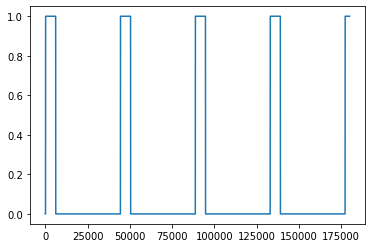

In [34]:
plt.plot(grey_periods)

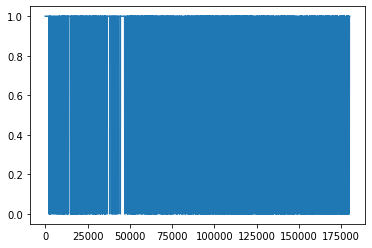

In [35]:
plt.plot(walking)

In [36]:
np.sum(walking==0), np.sum(walking==1)

(57311, 122689)

In [37]:
slice_avgs = []
for z in range(49):
    idx = np.ndarray.astype(timestamps[:,z]/10,'int')[:-1] # remove last idx because it could go over 1800s
    grey_and_stopped = np.logical_and(walking[idx] == 0, grey_periods[idx]==1)
    grey_and_walking = np.logical_and(walking[idx] == 1, grey_periods[idx]==1)
    grey_and_stopped = np.append(grey_and_stopped, False)
    slice_avgs.append(np.mean(all_signals[z,:,grey_and_stopped],axis=0))
baseline_brain = np.asarray(slice_avgs)
baseline_brain.shape
# this will be subtracted below

(49, 2000)

# make STA

In [38]:
###########################
### Create Notch Filter ###
###########################

fs = 10.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = .8  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response

w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

In [39]:
all_warps = {}
for condition in ['ve_0', 've_no_0']:#['ve_no_0', 've_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    STA_brain -= baseline_brain[:,np.newaxis,:]
    STA_brain = signal.filtfilt(b_notch, a_notch, STA_brain, axis=1)
    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    #STA_brain = reformed_STA_brain
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly=fly, fixed=fixed, anat_to_mean_type=anat_to_mean_type)
    all_warps[condition] = np.asarray(warps)
    print(F'Warps {time.time()-t0}')

ve_0
STA 0.7842955589294434
Warps 11.959634780883789
ve_no_0
STA 0.8084685802459717
Warps 11.82701849937439


In [42]:
from scipy.ndimage.filters import uniform_filter1d

In [43]:
#temp = gaussian_filter1d(all_warps['ve_0'],sigma=1,axis=0,truncate=1)
temp = uniform_filter1d(all_warps['ve_0'], size=3,axis=0)

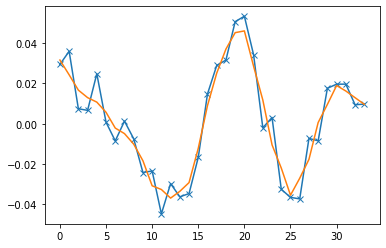

In [44]:
plt.plot(all_warps['ve_0'][:,100,100,40],marker='x')
plt.plot(temp[:,100,100,40])

In [45]:
all_warps['ve_0'].shape

(34, 314, 146, 91)

In [120]:
filename = os.path.join(func_path, 'STA', '20220524_luke_STA_all_warps.pickle')
with open(filename, 'wb') as handle:
    pickle.dump(all_warps, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
all_explosions = {}
for condition in ['ve_0', 've_no_0']:#['ve_no_0','ve_no_180','ve_0','ve_180']:
    explosions = []
    t0 = time.time()
    for tp in range(len(neural_bins)-1):
        input_canvas = np.ones((500,500,3))
        data_to_plot = all_warps[condition][tp,:,:,::-1]
        vmax = .5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions

Explosion 30.416221857070923


KeyboardInterrupt: 

In [120]:
def get_dim_info(item, full_x_mid, full_y_mid):
    y_mid = int(item.shape[0]/2)
    x_mid = int(item.shape[1]/2)

    height = item.shape[0]
    width = item.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height
    return {'left': left, 'right': right, 'top': top, 'bottom': bottom}

def place_roi_groups_on_canvas(explosion_rois, roi_masks, roi_contours, data_to_plot, input_canvas, vmax, cmap, diverging=False):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)
    
    for roi_group in explosion_rois:
        
        x_shift = explosion_rois[roi_group]['x_shift']
        y_shift = explosion_rois[roi_group]['y_shift']
        
        roi_data = []
        left_edges = []
        right_edges = []
        bottom_edges = []
        top_edges = []
        
        for roi in explosion_rois[roi_group]['rois']:
            mask = roi_masks[roi]
            #masked_roi = mask[...,np.newaxis]*data_to_plot # for 3 channel
            masked_roi = mask*data_to_plot

            ### maximum projection along z-axis
            # works for negative values
            maxs = np.max(masked_roi,axis=2)
            mins = np.min(masked_roi,axis=2)
            maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
            roi_data.append(maxs)
            #masked_roi_flat = maxs

            ### maximum projection along z-axis
            #masked_roi_flat = np.max(masked_roi,axis=2)
            #roi_data.append(masked_roi_flat)
            
            left_edges.append(roi_contours[roi]['left_edge'])
            right_edges.append(roi_contours[roi]['right_edge'])
            top_edges.append(roi_contours[roi]['top_edge'])
            bottom_edges.append(roi_contours[roi]['bottom_edge'])
        
            
        # get extreme edges from all rois used
        left_edge = np.min(left_edges) - 1
        right_edge = np.max(right_edges) + 1
        top_edge = np.min(top_edges) - 1
        bottom_edge = np.max(bottom_edges) + 1
        
        ### this projects across all the roi_data from each roi 
        #roi_datas = np.max(np.asarray(roi_data),axis=0) # this one line is sufficient for not diverging
        maxs = np.max(np.asarray(roi_data),axis=0)
        mins = np.min(np.asarray(roi_data),axis=0)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
        roi_datas = maxs

        ###ADD MAX MIN HERE LIKE ABOVE

        ### cutout this grouping
        #data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge,:],0,1) # for 3 channel
        data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
        ### apply gain
        #data_map = data_map * gain

        mycmap = matplotlib.cm.get_cmap(cmap)
        #mycmap.set_bad('k',1) # make nans black

        if diverging:
            # this will normalize all value to [0,1], with 0.5 being the new "0" basically
            # current issue - a zero that should be background now looks like negative.
            # solution: could use nans instead and set bad color
            # with diverging we should make background white!
            # so actually just set the input_canvas as 0.5!!!
            # then make contours nan and set back as black
            norm = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)
            data_map = norm(data_map)
        else:
            data_map = data_map/vmax
        
        data_map = mycmap(data_map)[...,:3] #lose alpha channel

        dims = get_dim_info(data_map, full_x_mid, full_y_mid)

        ### ADD TO CANVAS
        input_canvas[dims['top']+y_shift:dims['bottom']+y_shift,
                     dims['left']+x_shift:dims['right']+x_shift,
                     :3] = data_map
        

        ### ADD CONTOUR TO CANVAS
        for roi in explosion_rois[roi_group]['rois']:
            contour = roi_contours[roi]['contour']
            contour = np.swapaxes(contour[top_edge:bottom_edge,left_edge:right_edge],0,1)
            ys = np.where(contour[:,:,0]>0)[0] + dims['top'] + y_shift
            xs = np.where(contour[:,:,0]>0)[1] + dims['left'] + x_shift
            input_canvas[ys,xs]=1
    return input_canvas

In [88]:
import matplotlib
mymap = matplotlib.colors.ListedColormap(['w','r'])

In [91]:
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["w","red"])


AttributeError: 'str' object has no attribute 'N'

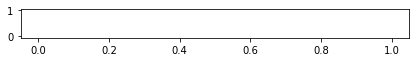

In [139]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap='inferno')

In [110]:
mycmap(0)

(1.0, 1.0, 1.0, 1.0)

In [151]:
all_explosions = {}
for condition in ['ve_0', 've_no_0']:#['ve_no_0','ve_no_180','ve_0','ve_180']:
    explosions = []
    t0 = time.time()
    tp = 10
    input_canvas = np.zeros((500,500,3))
    data_to_plot = all_warps[condition][tp,:,:,::-1]
    vmax = .6
    explosion_map = place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='inferno',
                                                        diverging=False)#'hot')
    explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions

Explosion 0.888679027557373
Explosion 0.9037070274353027


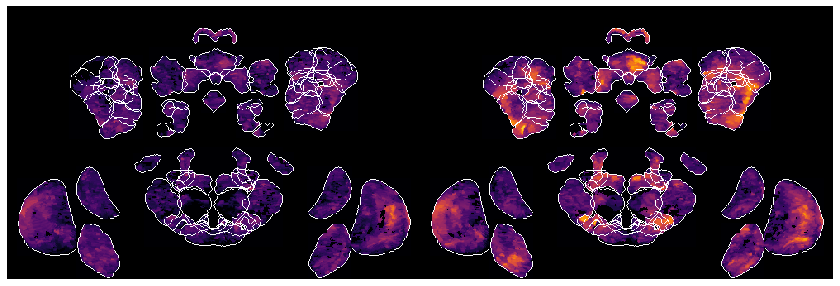

In [152]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(1,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

tp = 0
    
fig = plt.figure(figsize=(14.8,10))

plot_panel('ve_no_0', tp, 1)
plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
#plot_panel('ve_no_180', tp, 2)
plot_panel('ve_0', tp, 2)
#plot_panel('ve_180', tp, 4)
plt.subplots_adjust(hspace=0,wspace=0)
#plt.suptitle(f'20220524_{fly}',y=.9)

save_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20240122_fortom2.png'
# if not os.path.exists(save_path):
#     os.mkdir(save_path)
# fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
#plt.savefig(save_path,dpi=300,bbox_inches='tight')
# plt.close()

In [51]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(1,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

for tp in range(len(neural_bins)-1):
    print(tp)
    fig = plt.figure(figsize=(14.8,10))

    plot_panel('ve_no_0', tp, 1)
    plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
    #plot_panel('ve_no_180', tp, 2)
    plot_panel('ve_0', tp, 2)
    #plot_panel('ve_180', tp, 4)
    plt.subplots_adjust(hspace=0,wspace=0)
    #plt.suptitle(f'20220524_{fly}',y=.9)
    
    save_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220613_{fly}_movie'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [168]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(2,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

for tp in range(len(neural_bins)-1):
    print(tp)
    fig = plt.figure(figsize=(14.8,10))

    plot_panel('ve_no_0', tp, 1)
    plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
    plot_panel('ve_no_180', tp, 2)
    plot_panel('ve_0', tp, 3)
    plot_panel('ve_180', tp, 4)
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.suptitle(f'20220524_{fly}',y=.9)
    
    save_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220607_{fly}_movie'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


# ROIs over time

In [177]:
all_warps['ve_0'].shape

(30, 314, 146, 91)

In [37]:
roi_ids, names = brainsss.load_roi_hemi_ids()

In [108]:
roi_signal = {}
for signal_type in ['mean']:#['max', 'mean']:
    roi_signal[signal_type] = {}
    for hemi in ['right', 'left']:
        roi_signal[signal_type][hemi] = {}
        for condition in ['ve_0','ve_180','ve_no_0','ve_no_180']:
            roi_signal[signal_type][hemi][condition] = brainsss.extract_roi_signal_traces(roi_ids,
                                                                                roi_masks,
                                                                                all_warps,
                                                                                condition,
                                                                                hemi,
                                                                                signal_type)

83.54268193244934
82.61814451217651
82.77657961845398
83.39280438423157
82.14707064628601
81.54946827888489
82.75003743171692
81.89416360855103


In [171]:
def extract_roi_signal_traces(roi_ids, roi_masks, all_warps, condition, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = all_warps[condition][:,:,:,::-1]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [109]:
filename = os.path.join(func_path, 'STA', '20220607_luke_STA_roi_signal_filtered_extended.pickle')
with open(filename, 'wb') as handle:
    pickle.dump(roi_signal, handle, protocol=pickle.HIGHEST_PROTOCOL)

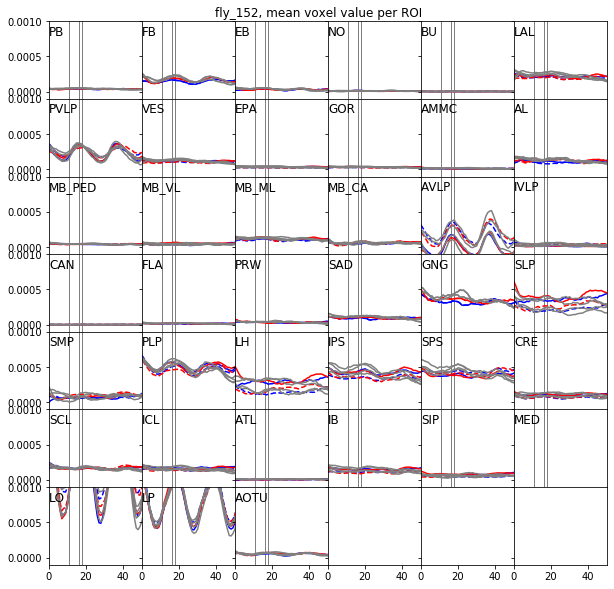

In [40]:
#full_left_group and STA_in_atlas_space_left should indeed both refer to the left brain

#right turn is blue, left turn is red
#solid line is left brain, dashed line is right brain

#so the general hypothesis is for solid lines the red should be higher, and for dashed line the blue should be higher
signal_type = 'mean'

#for max view we want x zoom in
if signal_type == 'max':
    roi_y_coor = .8
    roi_x_coor = 9
    vertical_lines = [11,16,18]
    x_start = 0#8
    x_end = 50#25
    y_start = 0
    y_end = 1
if signal_type == 'mean':
    roi_y_coor = 0.0008
    roi_x_coor = .2
    vertical_lines = [11,16,18]#[3,8,10]
    x_start = 0
    x_end = 50
    y_start = -0.0001
    y_end = 0.001

fig, ax = plt.subplots(7, 6, sharex='col', sharey='row', figsize=(10,10))
pltnum = 0
for i in range(7):
    for j in range(6):
        if pltnum == 39:
            break
        
        for line in vertical_lines:
            ax[i,j].axvline(line,linestyle='-',color='k',linewidth=.5)
        
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_0'][pltnum,:],color='blue',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_0'][pltnum,:],color='blue',linestyle='--')
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_180'][pltnum,:],color='red',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_180'][pltnum,:],color='red',linestyle='--')
        
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_no_0'][pltnum,:],color='grey',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_no_0'][pltnum,:],color='grey',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_no_180'][pltnum,:],color='grey',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_no_180'][pltnum,:],color='grey',linestyle='-')
        
        ax[i,j].text(roi_x_coor, roi_y_coor, names[pltnum],fontsize=12)
        ax[i,j].set_ylim(y_start,y_end)
        ax[i,j].set_xlim(x_start,x_end)
        
        pltnum += 1

plt.subplots_adjust(hspace=0,wspace=0)
plt.suptitle(f'{fly}, {signal_type} voxel value per ROI',y=.9)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')
